In [ ]:
import pandas as pd
import numpy as np

Примените изученные решения на фрагменте датасета платформы ZOZO для продажи одежды, приложенного к статье:<br>
Yuta Saito, Shunsuke Aihara, Megumi Matsutani, Yusuke Narita.<br>
**Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation**<br>
https://arxiv.org/abs/2008.07146

Датасет содержит собранные разными стратегиями (случайно и сэмплированием Томпсона) данные о результатах трёх экспериментов.

Пользователи и товары анонимизированы. Тестируется набор алгоритмов рекомендаций, пользователю предоставляются на выбор несколько предметов одежды, один из которых подобран алгоритмом.

`item_id` — идентификатор тестируемой группы<br>
`position` — позиция рекомендованного товара в демонстрируемом пользователю ряду<br>
`click` — произошёл ли клик по рекомендованному товару

In [4]:
bts_all = pd.read_csv("../data/obd/bts/all/all.csv")
bts_all

,Unnamed: 0,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,0,2019-11-24 00:00:17.004101+00:00,79,2,0,0.087125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,7bc94a2da491829b777c49c4b5e480f2,c39b0c7dd5d4eb9a18e7db6ba2f258f8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-11-24 00:00:19.715857+00:00,14,1,0,0.006235,81ce123cbb5bd8ce818f60fb3586bba5,2d03db5543b14483e52d761760686b64,2723d2eb8bba04e0362098011fa3997b,9bde591ffaab8d54c457448e4dca6f53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2019-11-24 00:01:04.303227+00:00,18,2,0,0.061300,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,c39b0c7dd5d4eb9a18e7db6ba2f258f8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2019-11-24 00:01:11.571162+00:00,28,1,0,0.019430,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,7bc94a2da491829b777c49c4b5e480f2,9bde591ffaab8d54c457448e4dca6f53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2019-11-24 00:02:41.811768+00:00,65,2,0,0.019375,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,2019-11-30 23:51:33.024621+00:00,35,1,0,0.020135,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,9996,2019-11-30 23:52:40.029821+00:00,60,1,0,0.033030,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,f97571b9c14a786aab269f0b427d2a85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,9997,2019-11-30 23:55:31.994701+00:00,52,3,0,0.001360,cef3390ed299c09874189c387777674a,f1c2d6a32ec39249160cf784b63f4c6f,2723d2eb8bba04e0362098011fa3997b,f97571b9c14a786aab269f0b427d2a85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,9998,2019-11-30 23:57:10.077484+00:00,39,3,0,0.097620,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,06128286bcc64b6a4b0fb7bc0328fe17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Зафиксируйте количество групп, участвующих в эксперименте.

In [5]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
k = len(bts_all.item_id.unique())
k

80

Далее построчно прочитайте датафрейм, на каждом шаге обновляя `impressions` и `clicks` по данным таблицы. Сохраните список групп, которые были бы выбраны на каждом шаге сэмплированием Томпсона. Первую группу выбрать равной первой группе в датафрейме. Начальные $\alpha$ и $\beta$ принять равными 1.

In [6]:
impressions = np.zeros(k)
clicks = np.zeros(k)

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
calculated_ids = []
chosen = 79
for index, row in bts_all.iterrows():
    calculated_ids.append(chosen)
    group = row['item_id']
    impressions[group] += 1
    clicks[group] += row['click']

    step_ctrs = [np.random.beta(1 + clicks[b], 1 + impressions[b] - clicks[b]) for b in range(k)]
    chosen = np.argmax(step_ctrs)

Посчитать, сколько было таких моментов времени, что вы и авторы датасета выбрали одну и ту же группу.

In [7]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
(bts_all.item_id == pd.Series(calculated_ids)).sum()

19

Постройте графики плотностей для полученного выбора групп и имеющегося в датасете.

<Axes: ylabel='Density'>

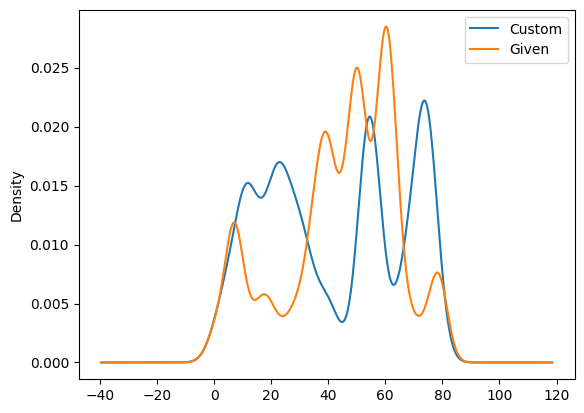

In [8]:
pd.Series(calculated_ids).plot.kde(legend=True, label='Custom')
bts_all.item_id.plot.kde(legend=True, label='Given')

Результаты не должны совпадать, так как при сборе данных выбирался топ-3 предсказанных CTR и использовались дополнительные оценки для выбора лучшего из них.